# PXD002801 Gygi lab mouse liver re-analysis

## Diversity Outbred (DO) Mice

## Quality control and sanity check notebook

### performed by Phil Wilmarth, PSR Core OHSU

#### November 5, 2025

---

- [Overview](#overview) 
- [Data loading](#load_data)
- [Removing plex effects with IRS](#IRS)
- [TMM normalization and final clustering](#TMM)
- [CV distributions](#CVs)
- [Sample-to-sample scatter plots](#scatter_plots)
- [Summary](#summary)

---

## <a name="overview"></a>Overview

This is a 21-plex experiment using 10-plex TMT with no reference channels per plex. Each plex is a set of biological replicates of mouse livers from the diversity outbred mice (192 mice livers with some repeated samples). Half the mice were fed a high-fat diet, and the other half were fed standard chow. There were equal numbers of male and female mice (one each per cross). Samples were randomly assigned to plexes to try and balance diet and sex. Data were downloaded from PRIDE (PXD002801) and processed with the [PAW Pipeline](https://github.com/pwilmart/PAW_pipeline) (*Wilmarth 2009*) and IRS normalized using the average of each plex as a mock reference channel. This is the publication:

> Chick, J.M., Munger, S.C., Simecek, P., Huttlin, E.L., Choi, K., Gatti, D.M., Raghupathy, N., Svenson, K.L., Churchill, G.A. and Gygi, S.P., 2016. Defining the consequences of genetic variation on a proteome-wide scale. Nature, 534(7608), pp.500-505.

This QC notebook will address these questions:

- Does internal reference scaling (IRS) (*Plubell 2017*) remove TMT plex "batch effects"?
- Do the samples cluster by biological group?
- Are normalization factors small and consistent?
- Are samples within groups similar to each other?

The sample key is a bit much for a table here. This is a somewhat balanced study design, so the average intensities for each protein in each plex might work for IRS.

### References

> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

> Plubell, D.L., Wilmarth, P.A., Zhao, Y., Fenton, A.M., Minnier, J., Reddy, A.P., Klimek, J., Yang, X., David, L.L. and Pamir, N., 2017. Extended multiplexing of tandem mass tags (TMT) labeling reveals age and high fat diet specific proteome changes in mouse epididymal adipose tissue. Molecular & Cellular Proteomics, 16(5), pp.873-890.

---

## This notebook examines quality control metrics

---

## Load the necessary R libraries

In [1]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘psych’


The following objects are masked from ‘package:scales’:

    alpha, rescale


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




## Define common functions for notebook use

In [2]:
# ================== TMM normalization from DGEList object =====================
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute and print "Sample loading" normalization factors
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size
    cat("\nLibrary size factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), lib_facs))
    
    # compute and print TMM normalization factors
    tmm_facs <- 1/y$samples$norm.factors
    cat("\nTrimmed mean of M-values (TMM) factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), tmm_facs))
    
    # compute and print the final correction factors
    norm_facs <- lib_facs * tmm_facs
    cat("\nCombined (lib size and TMM) normalization factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# ============== CV function ===================================================
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

# =========== Boxplot with median label ========================================
labeled_boxplot <- function(df, ylim, title) {
    # Makes a box plot with the median value labeled
        # df - data frame with data to compute CVs of
        # ylim - upper limit for y-axis
        # title - plot title
    cv = CV(df)
    boxplot(cv, ylim = c(0, ylim), notch = TRUE, main = title)
    text(x = 0.65, y = boxplot.stats(cv)$stats[3], 
         labels = round(boxplot.stats(cv)$stats[3], 1))
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

## <a name="load_data"></a>Load the IRS-normalized TMT intensity data

The input data for the notebook was prepped in Excel from the IRS script output. The protein table excludes decoys, contaminants, some major blood proteins, and any proteins not seen in all 4 plexes. 

In [3]:
# load the IRS-normalized data and check the table
data_irs <- read_tsv("quant_table.txt") 

# save gene names for edgeR so we can double check that results line up
accessions <- data_irs$Accession

# see how many rows of data we have
length(accessions)

Rows: 4804 Columns: 232
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr   (1): Accession
dbl (231): DO_1MH_1, DO_2MH_1, DO_3FH_1, DO_4MH_1, DO_5MS_1, DO_6FS_1, DO_7M...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 4804

### Collect channels by biological conditions 

The publication considered 4 groups by diet and sex. We will group the same way for this notebook.

In [4]:
# define the groups (after IRS)
FH_ <- select(data_irs, contains("FH_"))
cat("FH:", length(names(FH_)), "\n")
FS_ <- select(data_irs, contains("FS_"))
cat("FS:", length(names(FS_)), "\n")
MH_ <- select(data_irs, contains("MH_"))
cat("MH:", length(names(MH_)), "\n")
MS_ <- select(data_irs, contains("MS_"))
cat("MS:", length(names(MS_)), "\n")

FH: 50 
FS: 51 
MH: 58 
MS: 51 


### Make the organized data frames

We will put the organized data into a new data frame, define some column indexes for each biological group, and set colors for plotting.

In [5]:
# put groups together into a single data frame
tmt_irs <- bind_cols(FH_, FS_, MH_, MS_)

# data.frame(col_num = 1:ncol(tmt_irs), variable = colnames(tmt_irs))

In [6]:
# define which columns go with each group
FH <- 1:50
FS <- 51:101
MH <- 102:159
MS <- 160:210

# set some colors by group
colors_group = c(rep('dark red', 50), rep('pink', 51), rep('dark blue', 58), rep('light blue', 51)) 

## <a name="IRS"></a>Clustering before and after IRS

We would expect to see clustering by plex before adjusting intensities with the IRS method. This experiment does not have as balanced samples per plex as the other smaller two experiments did. The plex batch-like effect should be removed by the IRS method and the clustering after IRS should be by biological groups. If the biological group clustering cannot be recovered, the mock reference channel approach may not be appropriate for this data.

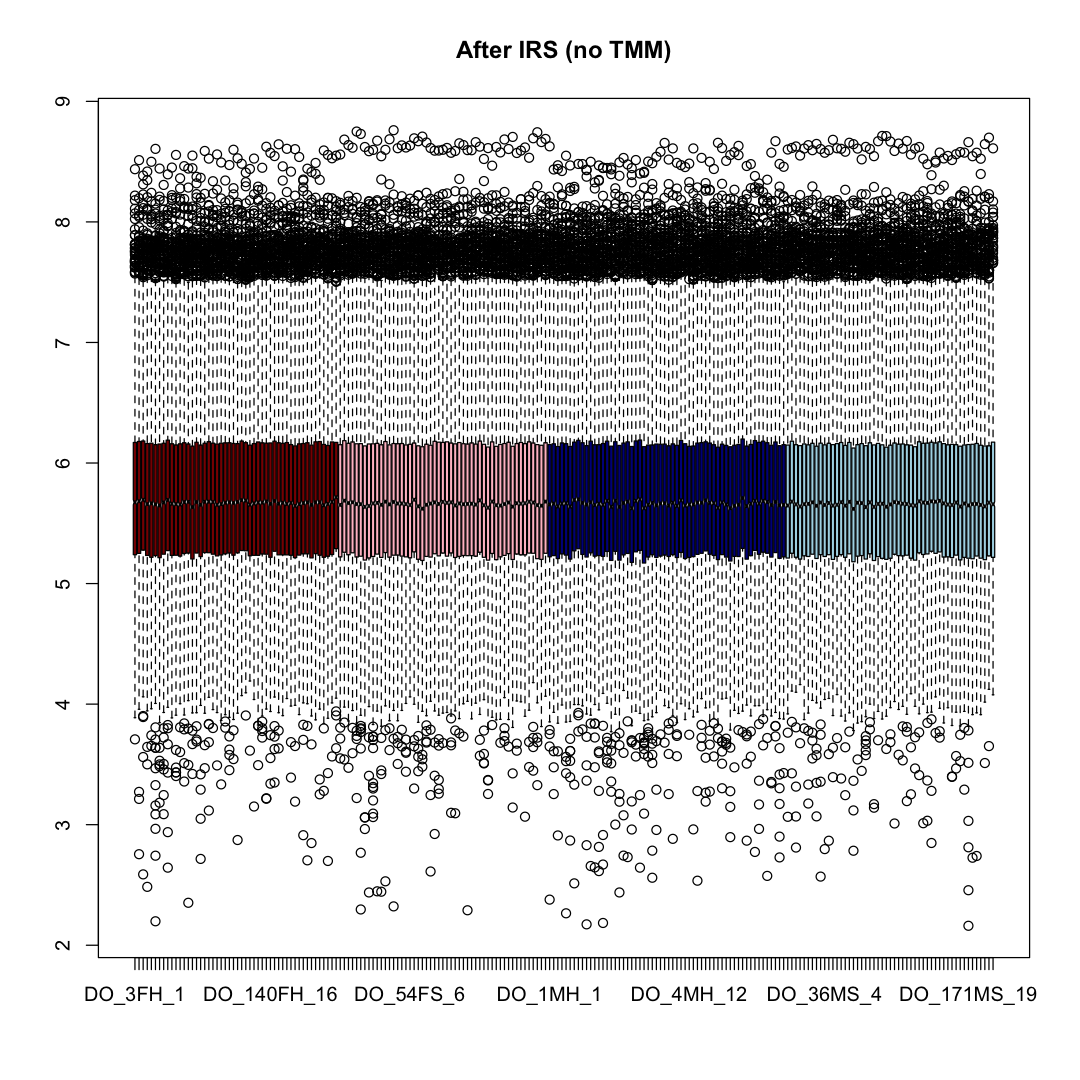

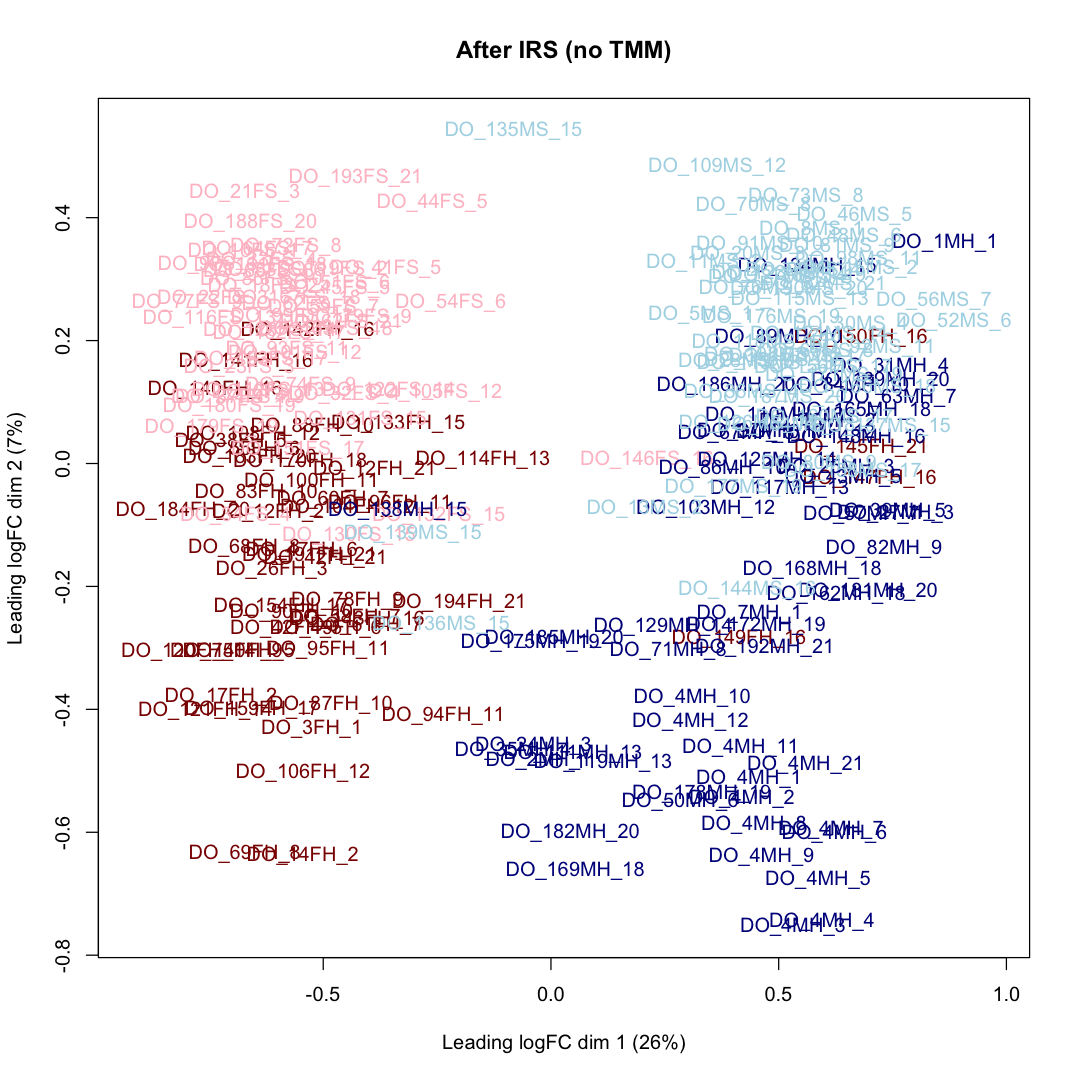

In [7]:
# make default plot sizes a little bigger
set_plot_dimensions(9, 9)

# boxplots after IRS and before TMM
boxplot(log10(tmt_irs), col = colors_group, notch = TRUE, main = "After IRS (no TMM)")

# check clustering before IRS
plotMDS(log2(tmt_irs), main = "After IRS (no TMM)", col = colors_group)

## <a name="TMM"></a>Run TMM normalization and check final clustering 

We will load the data into edgeR data structures and call the `calcNormFactors` function to perform library size and the trimmed mean of M-values (TMM) normalization to correct for any sample composition differences. We will double check if the TMM normalization changed the clustering that we had above. 

> Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

We need to use the edgeR normalization factors to produce the TMM normalized data that the statistical testing will be working with. EdgeR uses the normalization factors in its statistical modeling but does not output the normalized intensities. We compute the normalized intensities with the `apply_tmm_factors function`.


Library size factors:
 DO_3FH_1 -> 1.006862
 DO_12FH_2 -> 0.995895
 DO_14FH_2 -> 0.980331
 DO_17FH_2 -> 0.985833
 DO_26FH_3 -> 0.991650
 DO_38FH_5 -> 0.994687
 DO_40FH_5 -> 1.000440
 DO_42FH_5 -> 1.012346
 DO_47FH_6 -> 1.024000
 DO_49FH_6 -> 1.004147
 DO_55FH_6 -> 1.004504
 DO_58FH_7 -> 1.003737
 DO_60FH_7 -> 0.998770
 DO_61FH_7 -> 1.003351
 DO_68FH_8 -> 1.006505
 DO_69FH_8 -> 0.992929
 DO_75FH_9 -> 1.004702
 DO_78FH_9 -> 1.002452
 DO_83FH_10 -> 1.001996
 DO_87FH_10 -> 1.000672
 DO_88FH_10 -> 0.999882
 DO_90FH_10 -> 1.000161
 DO_94FH_11 -> 1.007224
 DO_95FH_11 -> 1.001026
 DO_96FH_11 -> 1.009083
 DO_100FH_11 -> 1.001989
 DO_104FH_12 -> 1.001875
 DO_106FH_12 -> 0.997668
 DO_108FH_12 -> 1.010022
 DO_114FH_13 -> 0.990233
 DO_120FH_14 -> 0.978154
 DO_121FH_14 -> 1.023491
 DO_133FH_15 -> 1.011545
 DO_140FH_16 -> 0.996985
 DO_141FH_16 -> 1.016052
 DO_142FH_16 -> 0.996990
 DO_143FH_16 -> 0.990118
 DO_147FH_16 -> 1.000110
 DO_149FH_16 -> 0.994751
 DO_150FH_16 -> 1.004654
 DO_154FH_17 -> 0.991

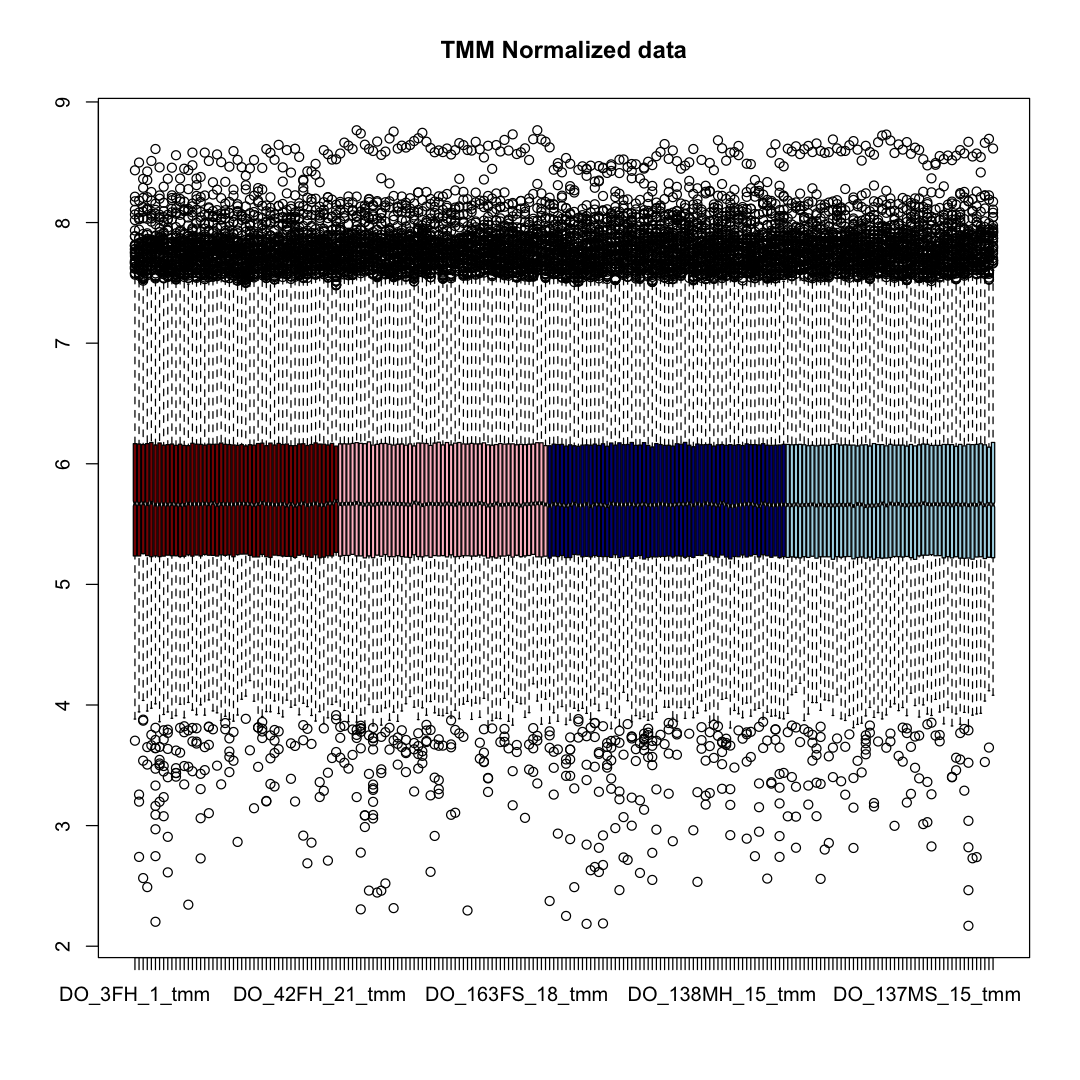

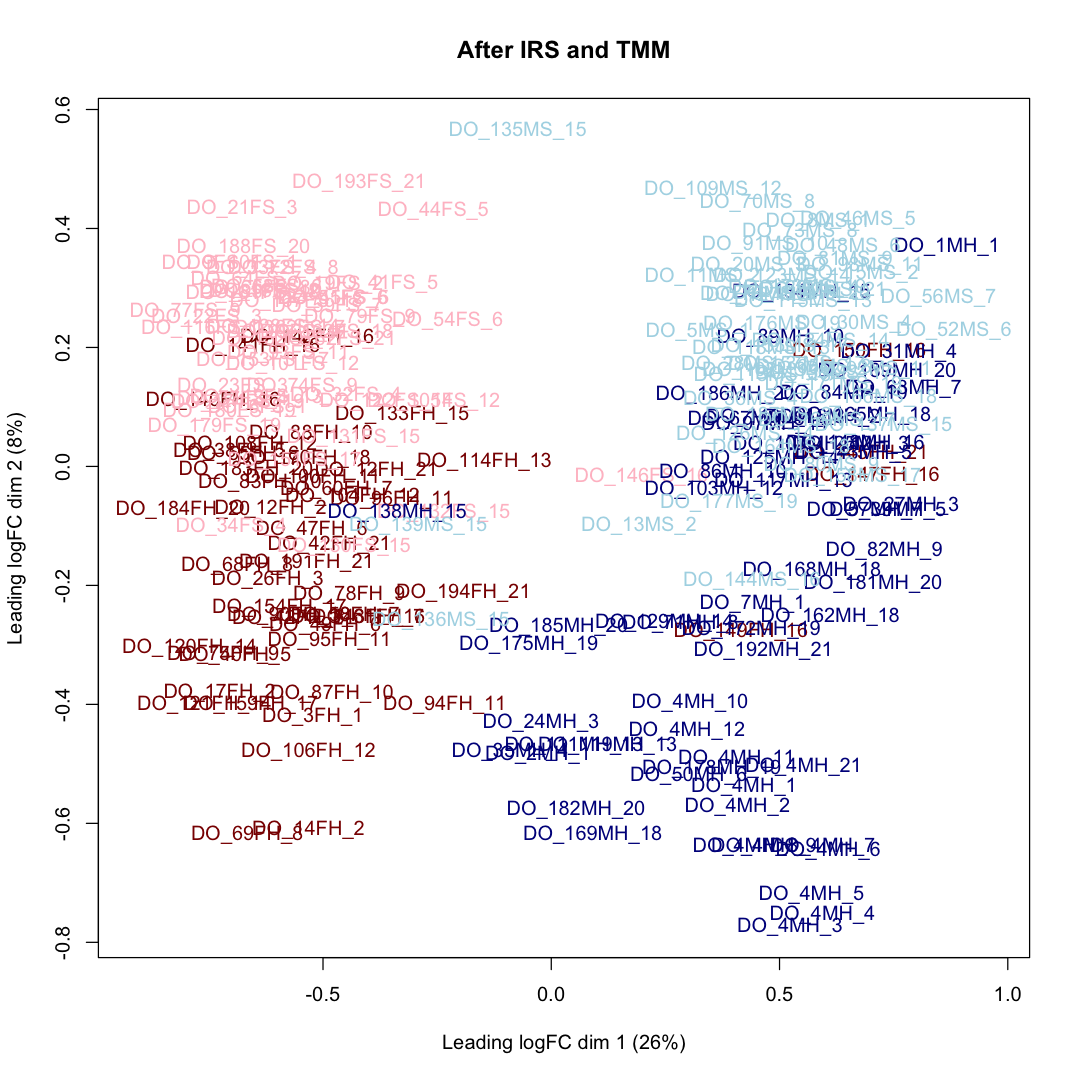

In [8]:
# get the biological sample data into a DGEList object
group = c(rep("FH", length(FH)), rep("FS", length(FS)),
          rep("MH", length(MH)), rep("MS", length(MS)))

y <- DGEList(counts = tmt_irs, group = group, genes = accessions)

# run TMM normalization (also includes a library size factor)
y <- calcNormFactors(y)

# compute the TMM-normalized intensities
tmt_tmm <- apply_tmm_factors(y, color = colors_group)

# write the TMM-normalized intensities to file
write.table(cbind(accessions,tmt_tmm), "DO_IRS-plus-TMM.txt", sep = "\t", 
            row.names = FALSE, na =  " ")

# check the clustering
plotMDS(y, col = colors_group, main = "After IRS and TMM")

### IRS and TMM seem to eliminate the plex effect

Boxplots and normalization factors suggest okay sample-to-sample similarity after IRS and TMM adjustments. The clustering looks biological (not by plex). We saw strong sex effects in the CC experiment, and we see that here with male samples on the right and female samples on the left. The diet choice shows top-to-bottom separation in both sexes, although the relative degree of variation is a lot larger for the x-axis than for the y-axis.

## <a name="CVs"></a>Check CV distributions

The distributions of Coefficients of Variation (CVs) are another way to get an idea of how individual proteins are behaving. This is an effective way to assess proper normalization in these experiments. We will compute CV distributions for each of the biological conditions.

In [9]:
# put CVs in data frames to simplify plots and summaries
# we will skip the n=1 group (TOFPS)
cv_tmm <- data.frame(FH = CV(tmt_tmm[FH]), FS = CV(tmt_tmm[FS]),
                     MH = CV(tmt_tmm[MH]), MS = CV(tmt_tmm[MS]))

medians <- apply(cv_tmm, 2, FUN = median)
print("Final median CVs by condition (%)")
round(medians, 2)

[1] "Final median CVs by condition (%)"


FH    FS    MH    MS 
15.09 12.75 16.32 13.58

#### Average median CV is 14.4%

The average median CV in this experiment is higher than we had for the CC experiment or the founder experiment. This probably reflects that the plexes are not as well balanced as in the two smaller experiments. It might also reflect more biological variability in the larger cohort of crosses.

### Use ggplot to visualize the CV distributions

We will look at the final IRS plus TMM normalized data here.

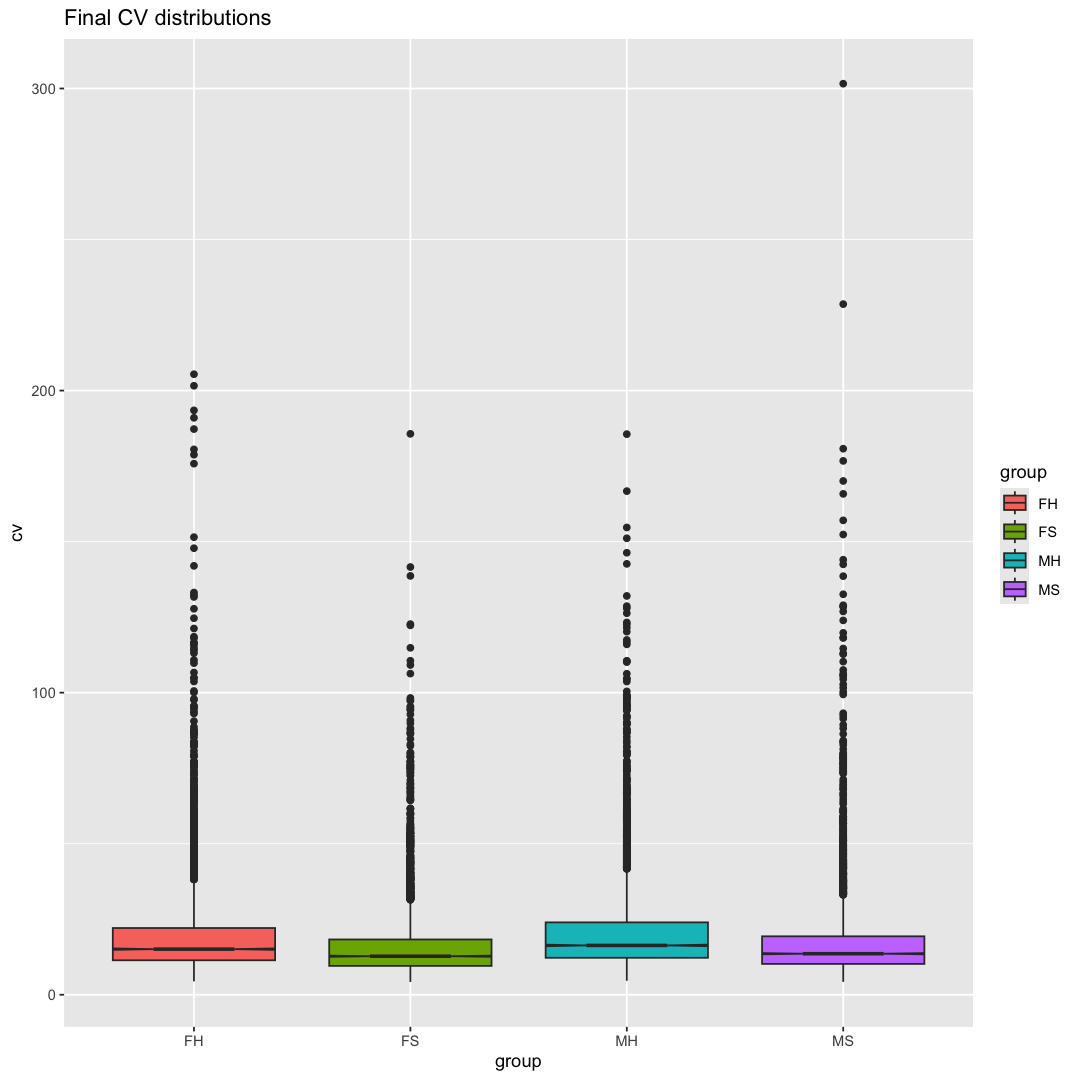

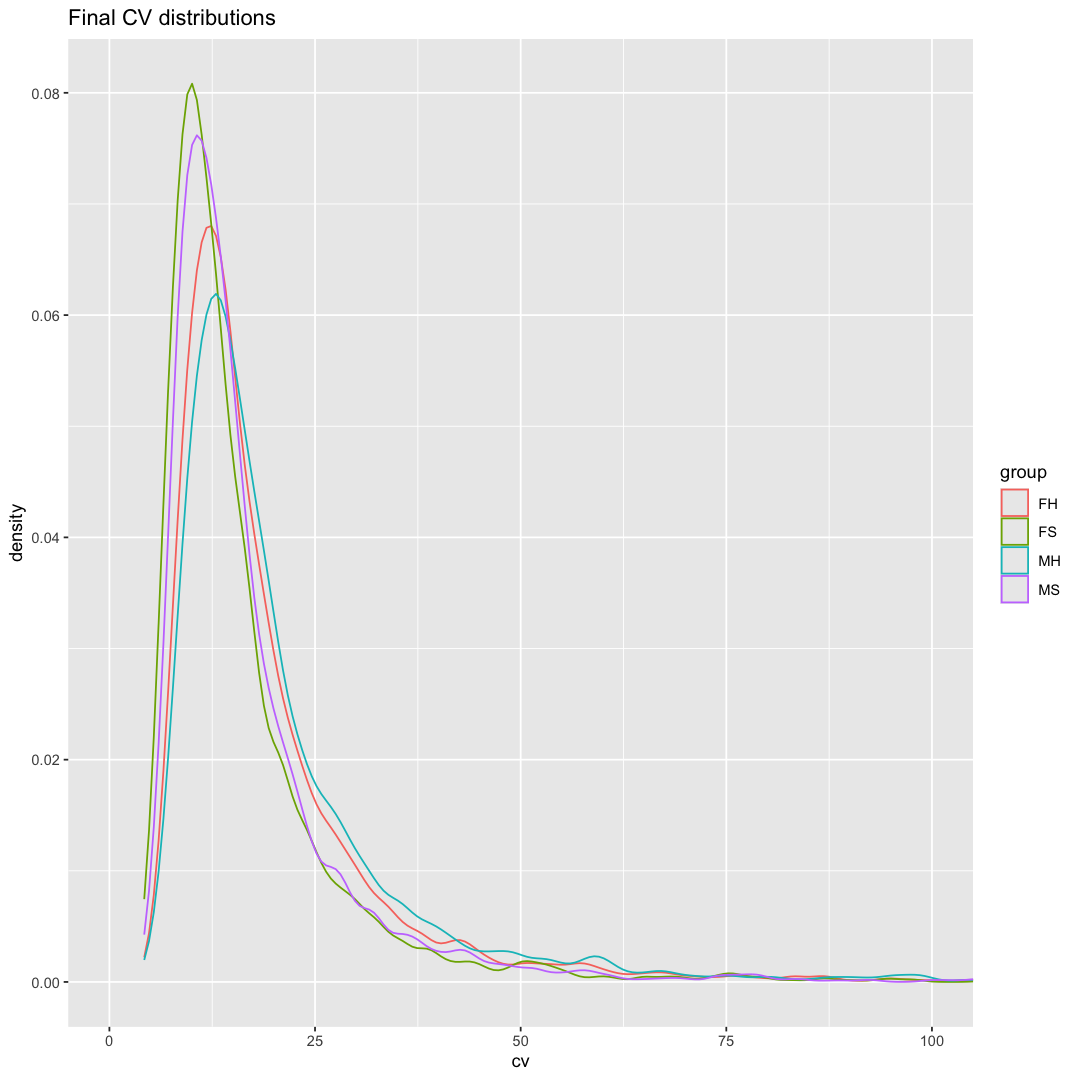

In [10]:
# see what the CV distibutions look like
# need long form for ggplot
long_cv_tmm <- gather(cv_tmm, key = "group", value = "cv") 

# traditional boxplots
ggplot(long_cv_tmm, aes(x = group, y = cv, fill = group)) +
  geom_boxplot(notch = TRUE) +
  ggtitle("Final CV distributions")

# density plots
ggplot(long_cv_tmm, aes(x = cv, color = group)) +
  geom_density() +
  coord_cartesian(xlim = c(0, 100)) +
  ggtitle("Final CV distributions")

#### The CV distributions are still narrow and similar

Even though the median CVs are a little higher, the shapes of the four CV distributions are very similar, and most CVs are relatively small (under 30%).

## <a name="scatter_plots"></a>Compare samples within each biological condition

We will need to draw some random subsets of samples in each group to have manageable scatter plot grids (5 or 6 sample is about as many as we can do).

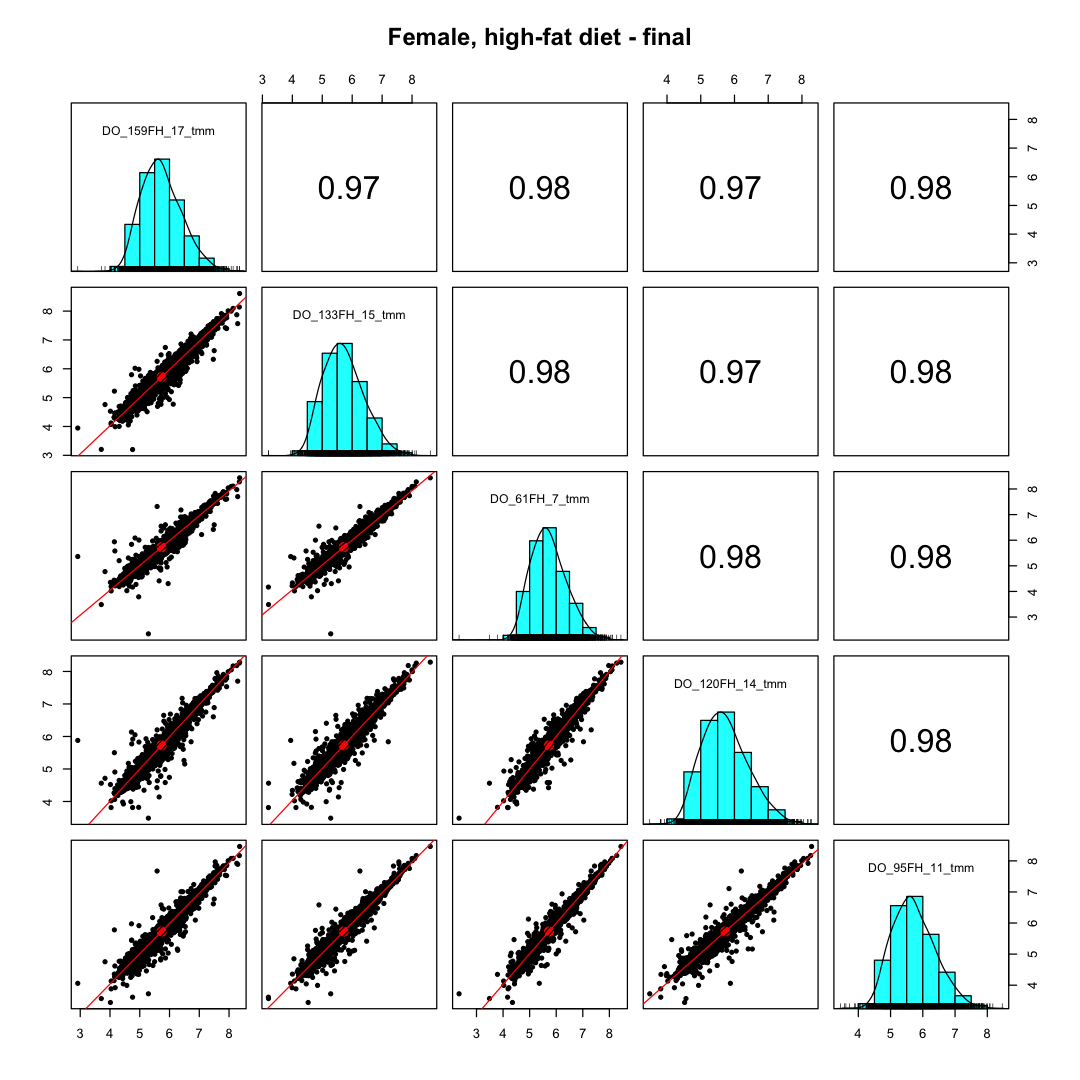

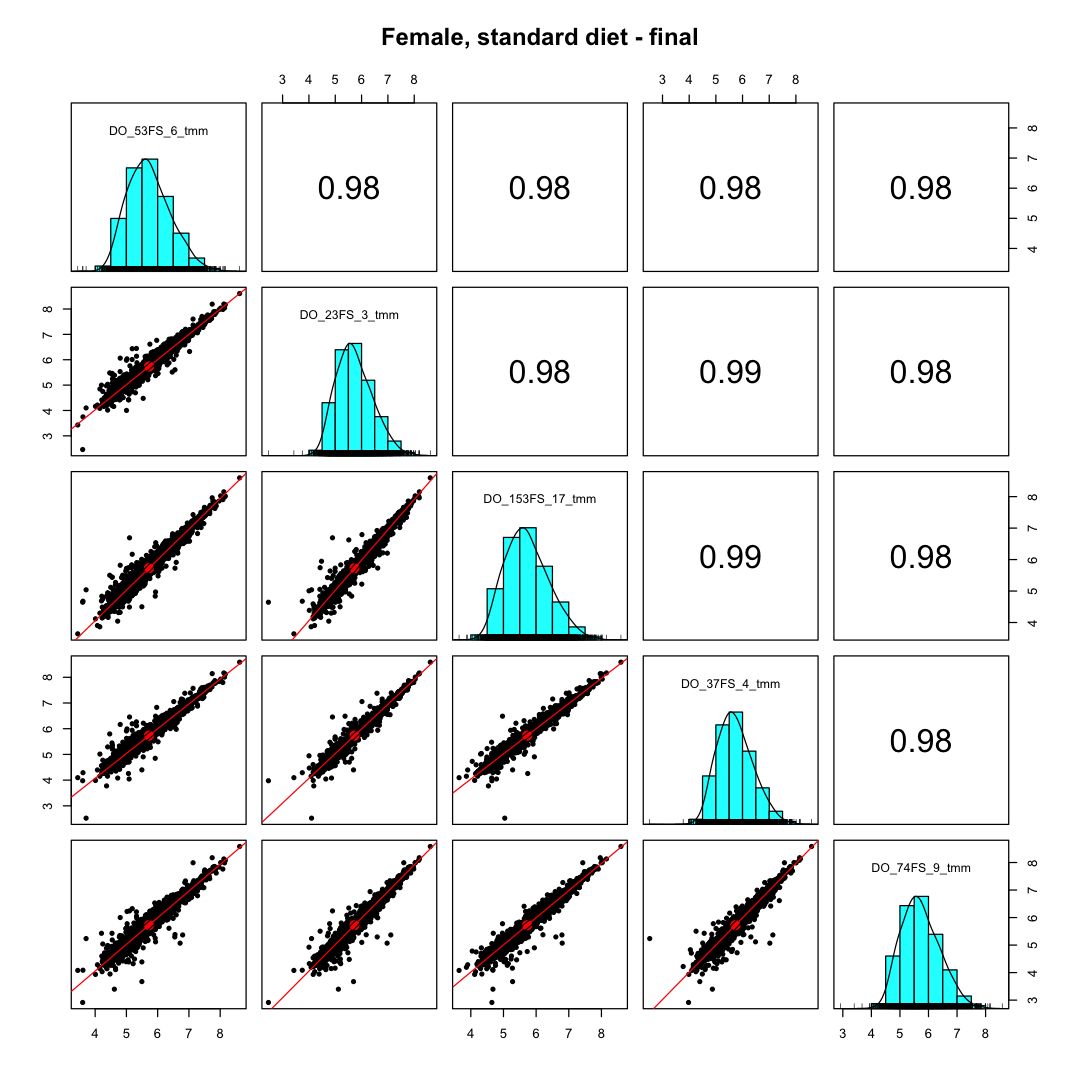

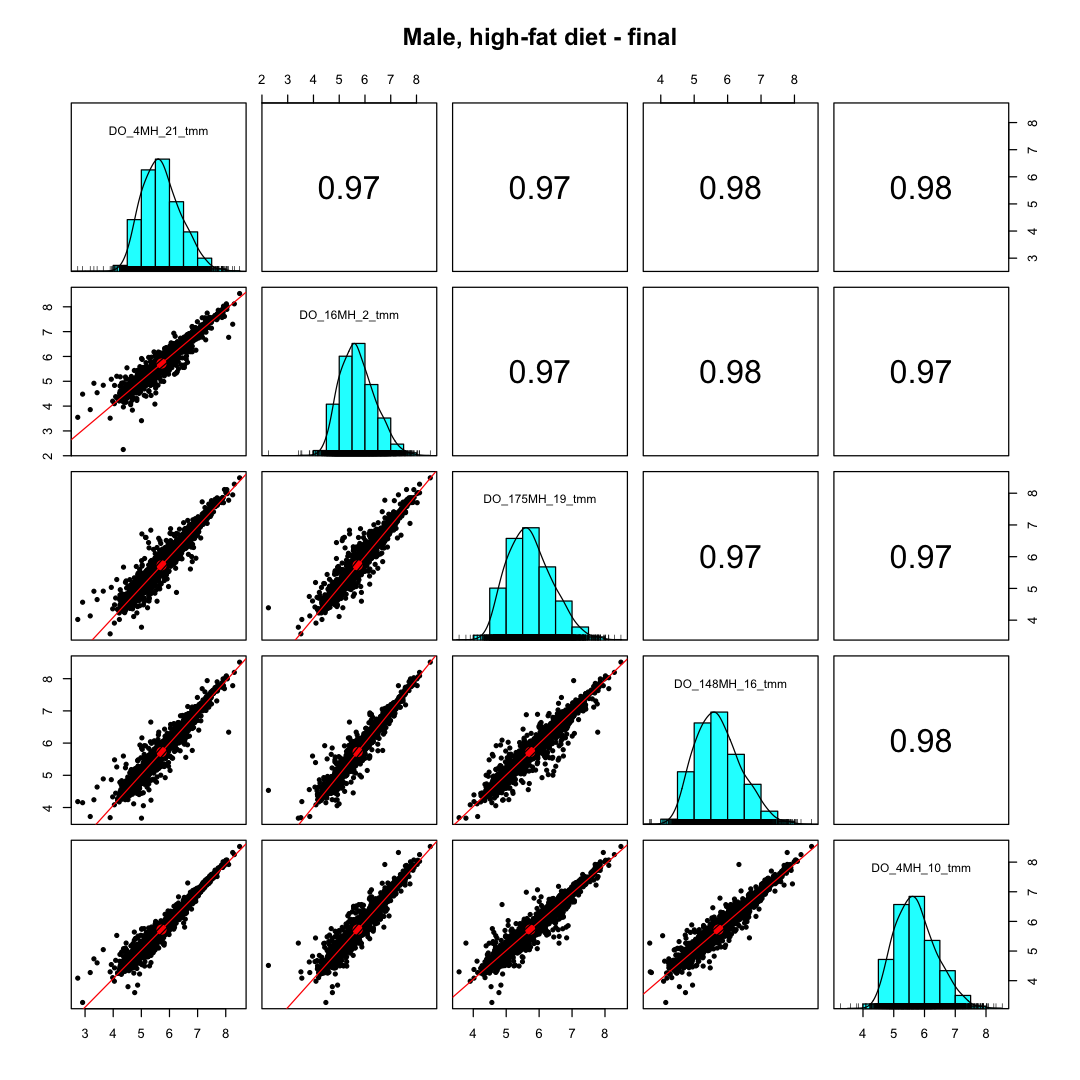

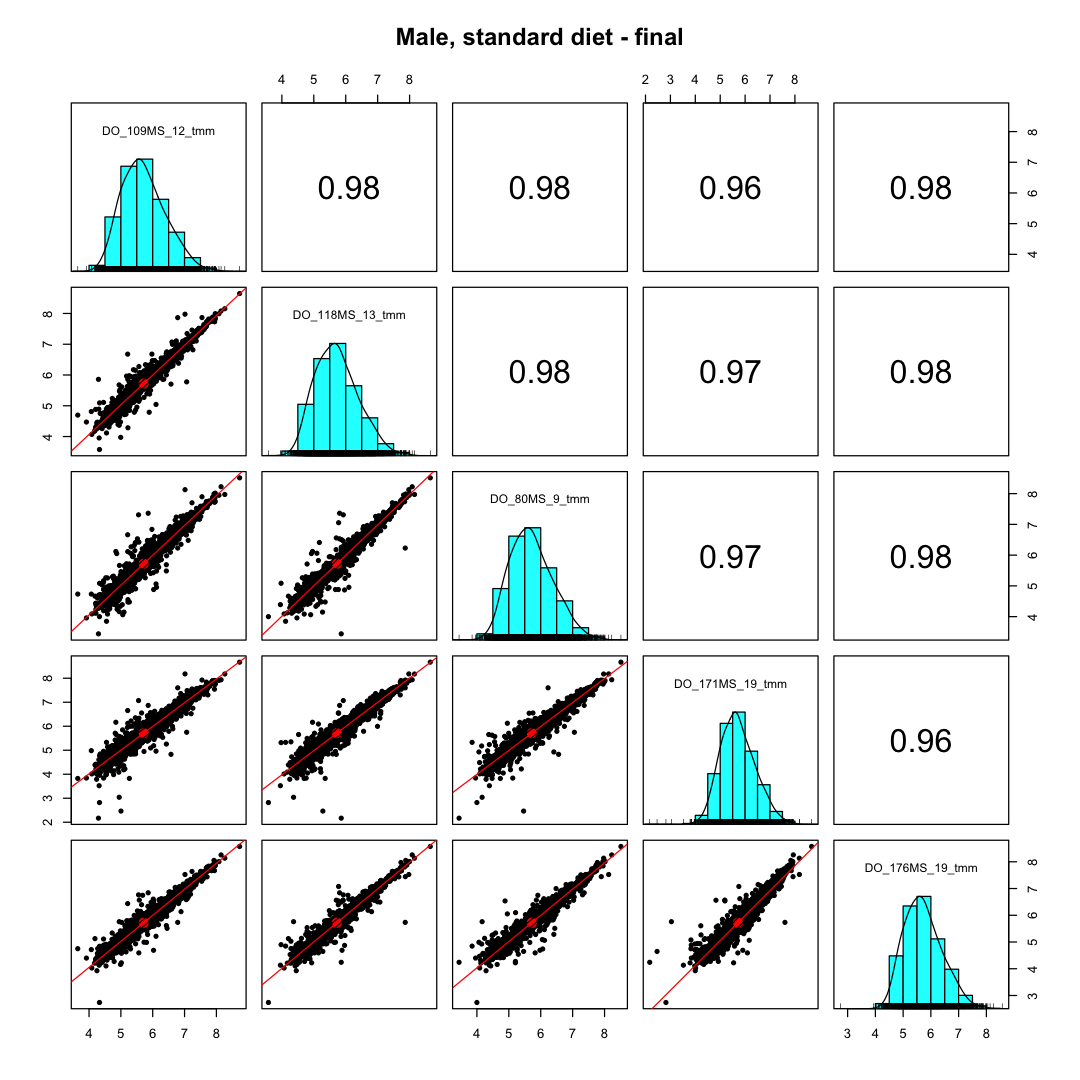

In [11]:
# multi-panel scatter plot grids, final data (random draws of 5 samples per group)
pairs.panels(log10(tmt_tmm[sample(FH, 5)]), lm = TRUE, main = "Female, high-fat diet - final")

pairs.panels(log10(tmt_tmm[sample(FS, 5)]), lm = TRUE, main = "Female, standard diet - final")

pairs.panels(log10(tmt_tmm[sample(MH, 5)]), lm = TRUE, main = "Male, high-fat diet - final")

pairs.panels(log10(tmt_tmm[sample(MS, 5)]), lm = TRUE, main = "Male, standard diet - final")

### Sample-to-sample correlations are okay

The scatter plots in each group show a little more scatter than we saw in the two smaller experiments. This might reflect the increased biological diversity in this experiment.

### Compare averages of each group to each other

We can get a little heads up on the statistical testing by comparing group averages to each other.

> NOTE: Correlation coefficients are not very informative in the scatter plot grids. The liver samples from the mice co-vary with protein relative abundance, so the coefficients are always close to 1.0. The (subjective) visual impression of degree of scatter is a more useful metric.

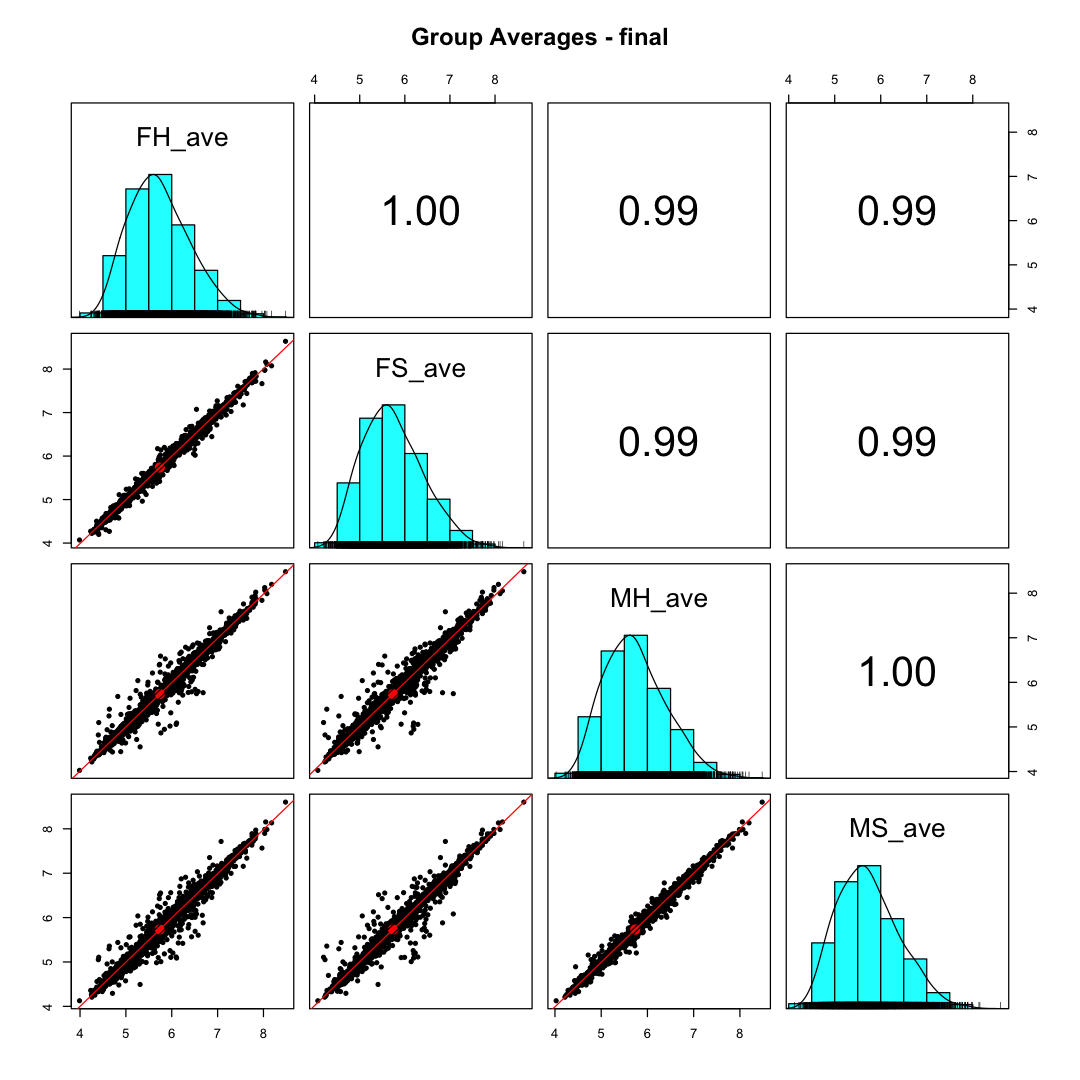

In [12]:
# save the dataframe with the averages by developmental age
ave_tmm <- cbind(FH_ave = rowMeans(tmt_tmm[FH]),
                 FS_ave = rowMeans(tmt_tmm[FS]),
                 MH_ave = rowMeans(tmt_tmm[MH]),
                 MS_ave = rowMeans(tmt_tmm[MS]))

# make a scatter plot grid for the group averages
pairs.panels(log10(ave_tmm), lm = TRUE, main = "Group Averages - final")

## <a name="summary"></a> Summary

The scatter plots of group averages indicate that the sex differences are quite a bit larger than the diet effect. The upper left and lower right scatter plots are tight to the diagonal trend line indicating a relatively small diet effect. Scatter plots between sexes, independent of diet, show many more proteins having larger abundance changes. Quality control checks seem okay. We can move on to any statistical testing.

## Log the session information

In [13]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-apple-darwin20
Running under: macOS 15.7.2

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_2.4.3     edgeR_4.2.0     limma_3.60.2    scales_1.3.0   
 [5] lubridate_1.9.3 forcats_1.0.0   stringr_1.5.1   dplyr_1.1.4    
 [9] purrr_1.0.2     readr_2.1.5     tidyr_1.3.1     tibble_3.2.1   
[13] ggplot2_3.5.1   tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] utf8_1.2.4        generics_0.1.3    stringi_1.8.4     lattice_0.22-6   
 [5] hms_1.1.3         digest_0.6.35     magrittr_2.0.3  